## One-shot voice conversion models for extracting speech content and style

**DEEP LEARNING PROJECT (FALL 2022)**

**1)Data Preprocessing**

In [10]:
import torch
from torch import nn, optim
from torch.nn import functional as F
import sys
import os
import argparse
import librosa
import librosa.display
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import glob
import random
import re
import matplotlib.pyplot as plt

from multiprocessing import Pool
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from tensorboardX import SummaryWriter
from torch import nn, optim
from torch.utils.data import DataLoader
import vq_model2
import vq_model3
import vq_model
import vq_model_simple
import train_normal

import soundfile as sf


In [2]:
class Audio2Mel(nn.Module):
    def __init__(self,
        n_fft=1024,#1024
        hop_length=256,
        win_length=1024,
        sampling_rate=24000, #22050,
        n_mel_channels=80, #80
        mel_fmin=0.0,
        mel_fmax=None,
        ):
        super().__init__()
        # FFT Parameters                              #
        ##############################################
        window = torch.hann_window(win_length).float()
        #It produces a linear transformation matrix to project FFT bins onto Mel-frequency bins
        mel_basis = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=n_mel_channels,  fmin=mel_fmin,  fmax=mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sampling_rate = sampling_rate
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
        )
        print(fft.shape) #N is the number of frequencies where STFT is applied and T is the total number of frames used.

        real_part, imag_part = fft.unbind(-1)#the last dimension represent the real and imaginary components
        magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2) #magnitude of the spectogram 
        mel_output = torch.matmul(self.mel_basis, magnitude)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec


def select_subjects(main_path,number_subjects):
    files=os.path.join(str(main_path),"p*")
    files = sorted(glob.glob(files))
    #Select number of subjects:
    return(random.sample(files, number_subjects))

def select_sentence(select_subj,batch_size):
    str_sentence= os.path.join(str(select_subj),"p*mic1.flac")
    files_sentence = sorted(glob.glob(str_sentence))
    return(random.sample(files_sentence, batch_size))

def load_audio(select_s):
    extract_func = Audio2Mel()
   
    sampling_rate = 24000#22050
    sr= sampling_rate
    x,_ = librosa.load(select_s, sr=sr)
    x, index = librosa.effects.trim(x, top_db=20) #To trim leading and trailing silence
    x=torch.from_numpy(x) #1D audio to a tensor 1x1xn
    x = x[None, None]

    mel = extract_func(x)
    mel = mel.numpy()
    mel = mel[0]
    return mel.astype(np.float32)

def visualize_spect(spec_x):
    d_db = librosa.power_to_db(spec_x,ref=np.max)
    plt.figure(1)
    librosa.display.specshow(d_db, sr=22050,y_axis='mel')
    plt.colorbar()
    plt.title('Spectogram')
    plt.xlabel('Time(s)')
    plt.ylabel('Frequency(Hz)')
    plt.show()


def select_data(main_path,out_dir,number_subjects,batch_size,our_audios):

    if our_audios==True:
        main_path= main_path+'own_audios/'
        s=os.path.join(str(main_path),"p*")
        files = sorted(glob.glob(s))
        for ind,f in enumerate(files):
                m=load_audio(f)
                out_fp = os.path.join(out_dir, f'p{ind}_{ind}.npy')
                np.save(out_fp, m, allow_pickle=False)

    else:
        select_subj= select_subjects(main_path,number_subjects)
        print(select_subj)
        print('Number of subjects',len(np.unique(select_subj)))

        for s in select_subj:
            sub= re.search('p+\d+',s).group(0)
            select_s= select_sentence(s,batch_size)
            print(select_s)
            #x=[load_audio(f) for f in select_s]
            for ind,f in enumerate(select_s):
                m=load_audio(f)
                visualize_spect(m)
                out_fp = os.path.join(out_dir, f'{sub}_{ind}.npy')
                np.save(out_fp, m, allow_pickle=False)

['wav48_silence_trimmed/p241', 'wav48_silence_trimmed/p227']
Number of subjects 2
['wav48_silence_trimmed/p241/p241_035_mic1.flac']
torch.Size([1, 513, 168, 2])


/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:606: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:803.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


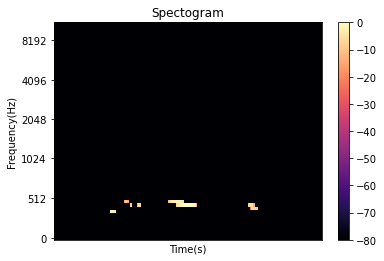

['wav48_silence_trimmed/p227/p227_316_mic1.flac']
torch.Size([1, 513, 112, 2])


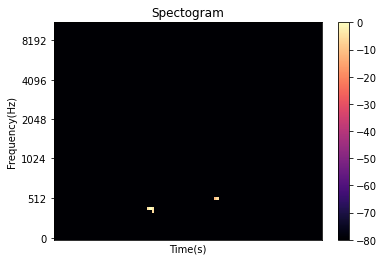

In [4]:
out_dir= 'output_train'
main_path= 'wav48_silence_trimmed/'
number_subjects= 2 #Number of subjects chosen randomly
batch_size= 1 #Number of sentence chosen randomly

select_data(main_path,out_dir,number_subjects,batch_size,our_audios=False)

**2)Model**

In [7]:
class AudioNpyLoader():
    def __init__(self, audio_path):
        self.audio_path = audio_path
        self.audios = os.listdir(self.audio_path)
        random.seed(1234)
        random.shuffle(self.audios)
    def __getitem__(self, index):
        item = f'{self.audio_path}/{self.audios[index]}'
        item = np.load(item, allow_pickle=True)
        return item
    def __len__(self):
        return len(self.audios)

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)
    def log_training(self, iteration,figure = "training.loss", **kwarg):
        self.add_scalars(figure, kwarg , iteration)
    def log_validation(self, iteration, **kwarg):
        for key in (kwarg.keys()):
            (type_, method_, data) = kwarg[key]
            if type_=="audio":
                self.add_audio(
                f'{key}',
                data, iteration, sample_rate=method_)
            elif type_ == "scalars":
                self.add_scalars("validation.loss", data, iteration)
            elif type_ == "image":
                data = data.detach().cpu().numpy()
                self.add_image(
                f'{key}',
                method_(data),
                iteration, dataformats='HWC')


def VCTK_collate(batch):
    maxn = 128
    audio = []
    #name = []
    for item in batch:
        item_len = int(item.shape[1])
        
        if item_len>maxn:
            rand = np.random.randint(item_len-maxn)
            item_128 = item[:,rand:rand+maxn]
        else:
            item_128 = item
        audio += [item_128]
    for i in range(len(audio)):
        a = audio[i]
        a = np.pad(a,((0,0),(0,maxn-a.shape[1])),'reflect')
        audio[i] = a
    return torch.tensor((np.array(audio)))

def make_inf_iterator(data_iterator):
    while True:
        for data in data_iterator:
            yield data

def prepare_directories_and_logger(logger_class, output_directory = 'output', 
	log_directory = 'log'):
    if not os.path.isdir(output_directory):
        os.makedirs(output_directory)
        os.chmod(output_directory, 0o775)
    logger = logger_class(os.path.join(output_directory, log_directory))
    return logger


Sequential(
  (0): Conv1d(80, 128, kernel_size=(4,), stride=(2,), padding=(1,))
  (1): ReLU()
  (2): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (3): ReLU()
  (4): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=(1,))
)
80
Sequential(
  (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): Upsample(size=80, mode=nearest)
)
torch.Size([128, 80, 4])
torch.Size([128])
torch.Size([256, 128, 3])
torch.Size([256])
torch.Size([256, 256, 1])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128, 256, 3])
torch.Size([128])
This is epoch number: 0
audio shape
torch.Size([1, 80, 128])
This is audio number: 0
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 2.5267146
input tor

torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0795808
audio shape
torch.Size([1, 80, 128])
This is audio number: 32
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0334446
audio shape
torch.Size([1, 80, 128])
This is audio number: 33
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Siz

audio shape
torch.Size([1, 80, 128])
This is audio number: 62
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0284958
audio shape
torch.Size([1, 80, 128])
This is audio number: 63
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.4633504
audio shape
torch.Size([1, 80, 128])
This is audio number: 64
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66]

torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.9181226
audio shape
torch.Size([1, 80, 128])
This is audio number: 94
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0577279
audio shape
torch.Size([1, 80, 128])
This is audio number: 95
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.91260344
audio shape
torch.Size([1, 80, 128])
This is 

audio shape
torch.Size([1, 80, 128])
This is audio number: 128
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.85858136
audio shape
torch.Size([1, 80, 128])
This is audio number: 129
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.79748267
audio shape
torch.Size([1, 80, 128])
This is audio number: 130
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256

torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.197993
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
Saving model and optimizer state at iteration 160
audio shape
torch.Size([1, 80, 128])
This is audio number: 1
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.924923
audio shape
torch.Size([1, 80, 128])
This is audio nu

q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.1311463
audio shape
torch.Size([1, 80, 128])
This is audio number: 38
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.81609786
audio shape
torch.Size([1, 80, 128])
This is audio number: 39
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.

q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.8895563
audio shape
torch.Size([1, 80, 128])
This is audio number: 73
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.83314836
audio shape
torch.Size([1, 80, 128])
This is audio number: 74
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.

torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0701284
audio shape
torch.Size([1, 80, 128])
This is audio number: 110
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.90828943
audio shape
torch.Size([1, 80, 128])
This is audio number: 111
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.8647597
audio shape
torch.Size([1, 80, 128])
This i

torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.8225273
audio shape
torch.Size([1, 80, 128])
This is audio number: 144
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.2473005
audio shape
torch.Size([1, 80, 128])
This is audio number: 145
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.S

audio shape
torch.Size([1, 80, 128])
This is audio number: 19
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.90380275
audio shape
torch.Size([1, 80, 128])
This is audio number: 20
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.9268777
audio shape
torch.Size([1, 80, 128])
This is audio number: 21
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66

q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.84784544
audio shape
torch.Size([1, 80, 128])
This is audio number: 57
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 1.0777533
audio shape
torch.Size([1, 80, 128])
This is audio number: 58
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.

audio shape
torch.Size([1, 80, 128])
This is audio number: 92
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.78929794
audio shape
torch.Size([1, 80, 128])
This is audio number: 93
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.9213167
audio shape
torch.Size([1, 80, 128])
This is audio number: 94
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66

out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.81357825
audio shape
torch.Size([1, 80, 128])
This is audio number: 127
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.85421276
audio shape
torch.Size([1, 80, 128])
This is audio number: 128
input torch.Size([1, 80, 128])
out_enc torch.Size([1, 256, 66])
q torch.Size([1, 256, 66])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara torch.Size([1, 128, 80])
torch.Size([1, 256, 66])
anna
torch.Size([1, 256, 66])
ara

ara torch.Size([1, 128, 80])
ARA
torch.Size([1, 128, 80])
torch.Size([1, 80, 128])
Loss value: 0.8115758
FINISH


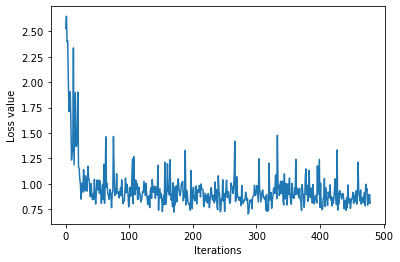

In [9]:
logger = prepare_directories_and_logger(Logger, output_directory = 'results/modelDL')

#Train Dataset
audio_path= 'train/'
dataTrain= AudioNpyLoader(audio_path)
loader = DataLoader(dataTrain, batch_size=1, shuffle=True,collate_fn=VCTK_collate)

#Test Dataset
audio_path_test= 'test/'
dataTest = AudioNpyLoader(audio_path_test)
test_loader = DataLoader(dataTest, batch_size=1, shuffle=True,collate_fn=VCTK_collate)
inf_iterator_test = make_inf_iterator(test_loader)

n= 128#128 #number of vectors in the codebook
ch= 128 #channels in encoder and decoder

#model initialization,  B x F x T tensor , where F is the number of input channels
model = vq_model2.VC_MODEL(in_channel=80,channel=ch,n_embed=n)
#model=vq_model_simple.VC_MODEL(in_channel=80,channel=ch,n_embed=n)
opt = optim.Adam(model.parameters())
for el in model.parameters():
    print(el.shape)

#Training
criterion = nn.L1Loss()
latent_loss_weight = 0.1
iteration = 0


#Run model
train_normal.train_(model, opt, latent_loss_weight, criterion, loader,3, inf_iterator_test, logger, iteration)
print('FINISH')


**3)Testing**